# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
display (feat_info.head (n=15))

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)

#float(len(azdias[azdias.AGER_TYP == 0]))/len(azdias)

#print(azdias.iloc[-1])
display (azdias.head (n=15))

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

There seems to be lot of missing data in the demographics data as is highlighted in above cells.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

#capture missing or unknows values from feture attributes summary

missing = azdias.isnull().sum()
print(type(missing))
#print(missing)
#null_data = azdias.isnull().sum()[azdias.isnull().sum() != 0]
#print(null_data)
azdias.isnull().sum().sum()




<class 'pandas.core.series.Series'>


4896838

In [33]:
for idx in range(len(feat_info)):
    unwanted = feat_info.iloc[idx]['missing_or_unknown']
    unwanted = unwanted.strip('[').strip(']').split(sep=',')

    unwanted = [float(value) if (value!='X' and value!='XX' and value!='') else value for value in unwanted]
    if unwanted != ['']:
        azdias = azdias.replace({feat_info.iloc[idx]['attribute']: unwanted}, np.nan)


In [34]:
azdias.info()
percent_missing_per_column =(azdias.isnull().sum()/len(azdias))*100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

In [35]:
display (azdias.head (n=15))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [36]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing = azdias.isnull().sum()
missing = missing[missing > 0]/(azdias.shape[0]) * 100
missing.sort_values(inplace=True)
print(missing)
y = missing[missing>40]
print("\n\nColumns with percentage greater than 40 are \n{}".format(y))

ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GFK_URLAUBERTYP           0.544646
ONLINE_AFFINITAET         0.544646
RETOURTYP_BK_S            0.544646
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
HH_EINKOMMEN_SCORE        2.058749
ANZ_PERSONEN              8.247000
SOHO_KZ                   8.247000
ANZ_TITEL                 8.247000
WOHNDAUER_2008            8.247000
KONSUMNAEHE               8.299737
LP_FAMILIE_GROB           8.728699
LP_FAMILIE_FEIN           8.728699
GEBAEUDETYP              10.451729
WOHNLAGE                 10.451729
OST_WEST_KZ              10.451729
MIN_GEBAEUDEJAHR         10.451729
GEBAEUDETYP_RASTER       10.452514
EWDICHTE                 10.518154
BALLRAUM                 10.518154
INNENSTADT               10.518154
LP_LEBENSPHASE_GROB      10.611509
ANZ_HH_TITEL             10.884842
ORTSGR_KLS9              10.914689
ARBEIT                   10.926022
RELAT_AB                 10.926022
LP_LEBENSPHASE_FEIN 

(array([ 7.,  1.,  0.,  0.,  0.,  0.,  0.,  4.,  3.,  0., 18.,  3., 10.,
         0.,  6.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.32326438,  1.31760809,  2.31195181,  3.30629552,  4.30063924,
         5.29498295,  6.28932667,  7.28367038,  8.2780141 ,  9.27235781,
        10.26670153, 11.26104524, 12.25538896, 13.24973267, 14.24407639,
        15.2384201 , 16.23276382, 17.22710753, 18.22145124, 19.21579496,
        20.21013867, 21.20448239, 22.1988261 , 23.19316982, 24.18751353,
        25.18185725, 26.17620096, 27.17054468, 28.16488839, 29.159232

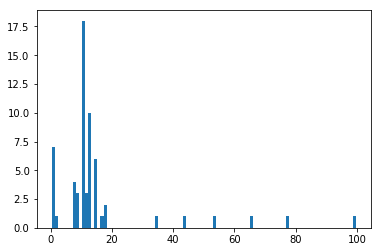

In [37]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing, bins = 100)


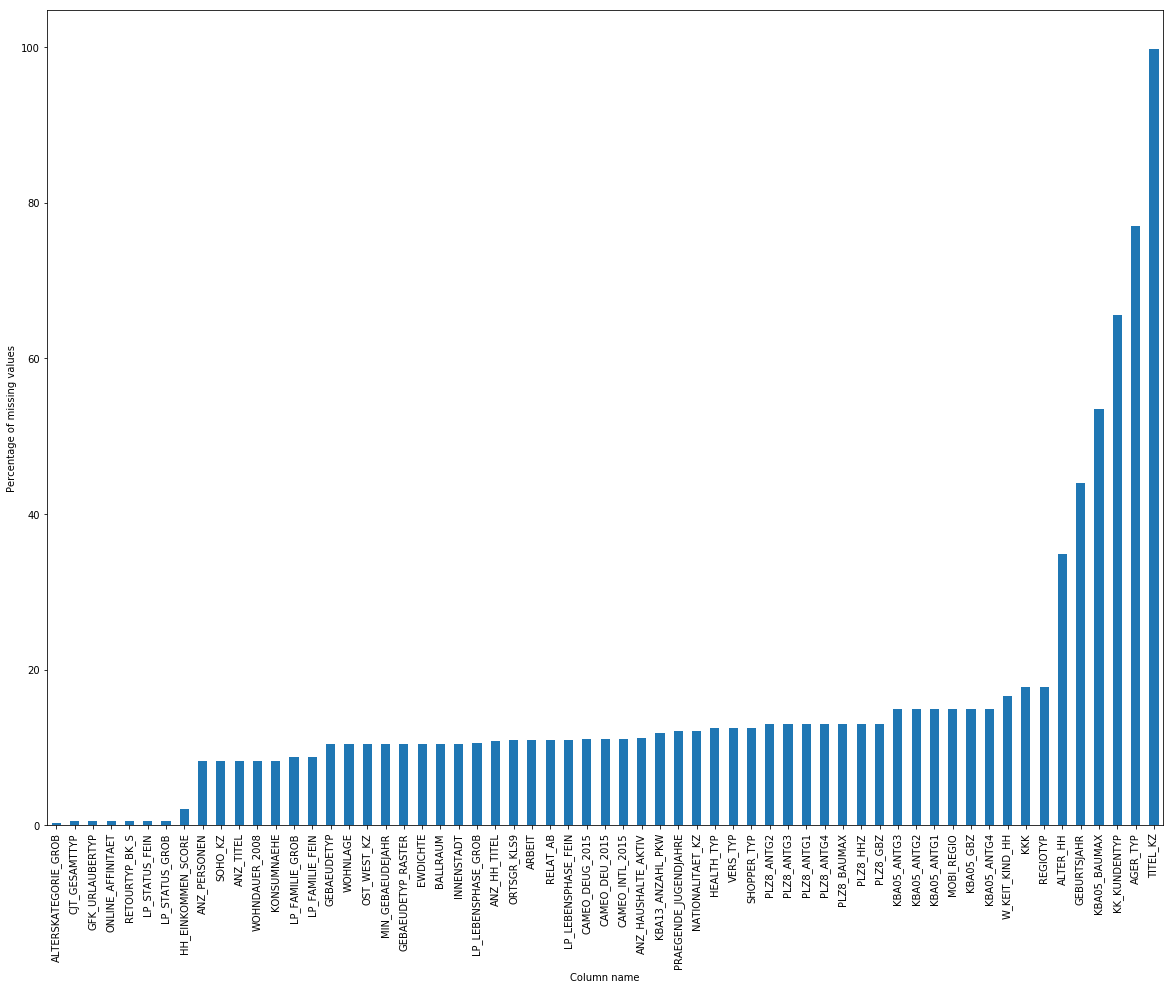

In [38]:
missing.plot.bar(figsize=(20,15))
plt.xlabel('Column name')
plt.ylabel('Percentage of missing values')

plt.show()


In [39]:
feat_info.iloc[14:42]
feat_info.iloc[14:]

,attribute,information_level,type,missing_or_unknown
14,HEALTH_TYP,person,ordinal,"[-1,0]"
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
23,RETOURTYP_BK_S,person,ordinal,[0]


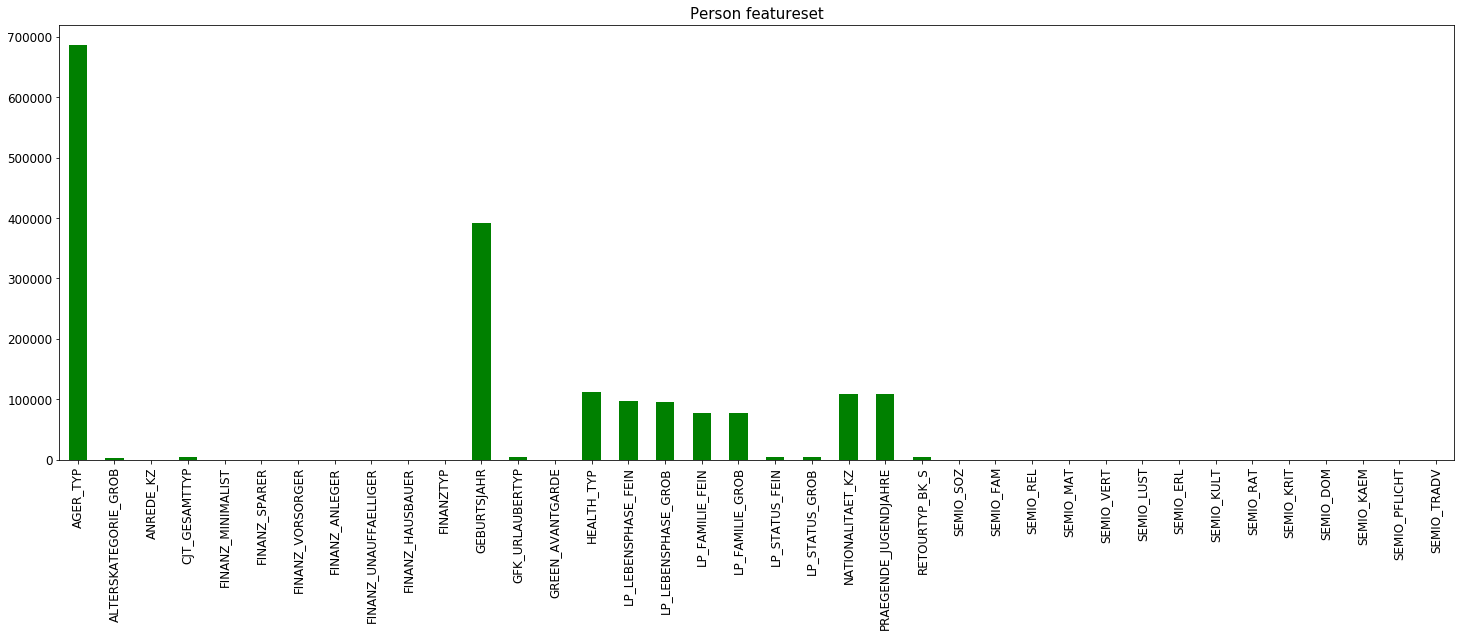

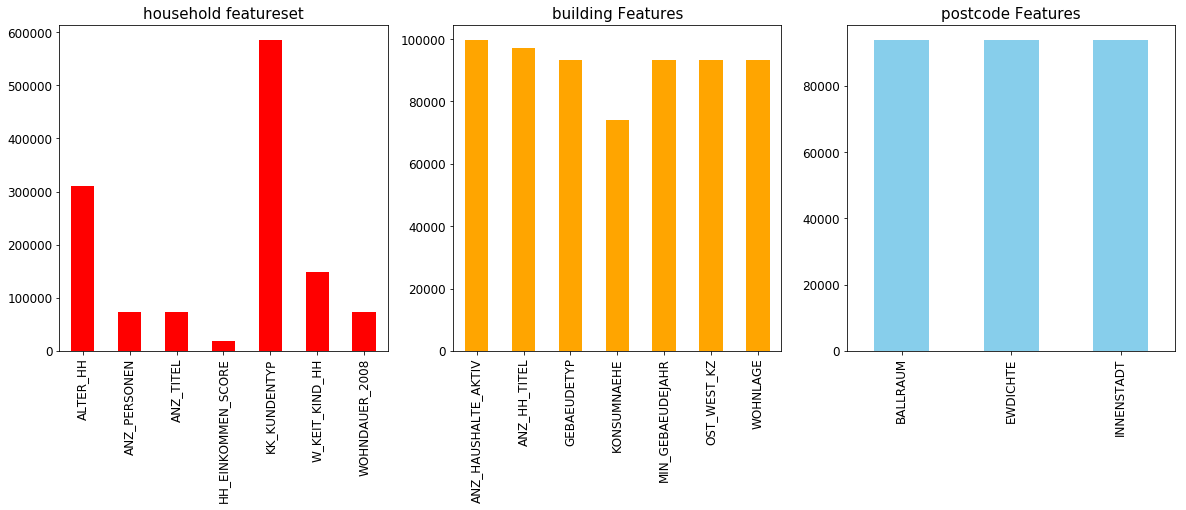

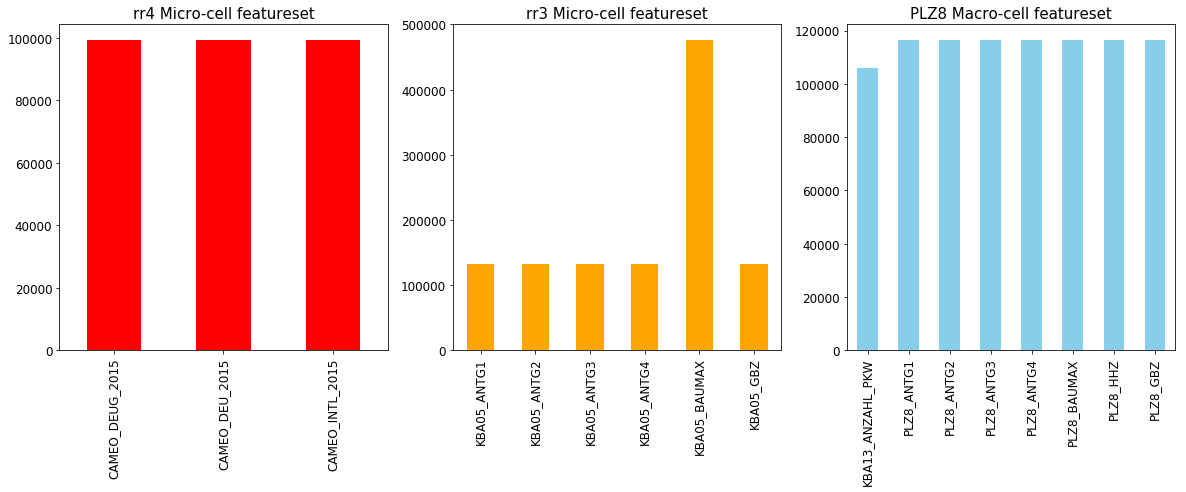

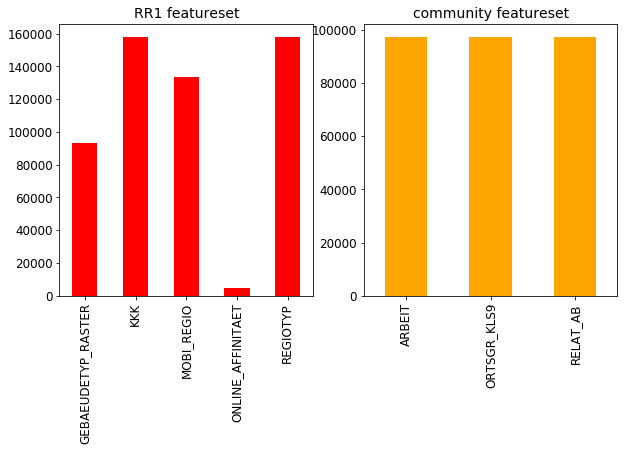

In [40]:
plt.figure(1,figsize=(25,8))
plt.subplot(111)
azdias.loc[:,'AGER_TYP':'SEMIO_TRADV'].isnull().sum().plot.bar(fontsize=12,color='green')
plt.title('Person featureset',fontsize=15)

plt.figure(2,figsize=(20,6))
plt.subplot(131)
azdias.loc[:,'ALTER_HH':'WOHNDAUER_2008'].isnull().sum().plot.bar(fontsize=12,color='red')
plt.title('household featureset',fontsize=15)

plt.subplot(132)
azdias.loc[:,'ANZ_HAUSHALTE_AKTIV':'WOHNLAGE'].isnull().sum().plot.bar(fontsize=12,color='orange')
plt.title('building Features',fontsize=15)

plt.subplot(133)
azdias.loc[:,'BALLRAUM':'INNENSTADT'].isnull().sum().plot.bar(fontsize=12,color='skyblue')
plt.title('postcode Features',fontsize=15)

plt.figure(3,figsize=(20,6))
plt.subplot(131)
azdias.loc[:,'CAMEO_DEUG_2015':'CAMEO_INTL_2015'].isnull().sum().plot.bar(fontsize=12,color='red')
plt.title('rr4 Micro-cell featureset',fontsize=15)

plt.subplot(132)
azdias.loc[:,'KBA05_ANTG1':'KBA05_GBZ'].isnull().sum().plot.bar(fontsize=12,color='orange')
plt.title('rr3 Micro-cell featureset',fontsize=15)

plt.subplot(133)
azdias.loc[:,'KBA13_ANZAHL_PKW':'PLZ8_GBZ'].isnull().sum().plot.bar(fontsize=12,color='skyblue')
plt.title('PLZ8 Macro-cell featureset',fontsize=15)

plt.figure(4,figsize=(10,5))
plt.subplot(121)
azdias.loc[:,'GEBAEUDETYP_RASTER':'REGIOTYP'].isnull().sum().plot.bar(fontsize=12,color='red')
plt.title('RR1 featureset',fontsize=14)

plt.subplot(122)
azdias.loc[:,'ARBEIT':'RELAT_AB'].isnull().sum().plot.bar(fontsize=12,color='orange')
plt.title('community featureset',fontsize=14)

plt.show()

In [41]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']
azdias = azdias.drop(drop_columns, axis=1)



In [42]:
display(azdias.head(n=15))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

I see that few features are missing more than 40% of their values:
'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'.

GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636

Safe to say these are outliers and we can take them out.

Also looking at the missing charts of cetain group of fetaures it looks like that data is missing in groups for certain categories. For example micro_cell features and macro_cell featres seem to have same amount of missing data.
Same applies to community features, post code features. It gives some sort of hint at the data collection process where some groups had data missing together.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

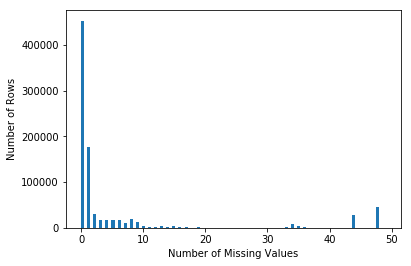

0         44
1          1
2          0
3          7
4          0
5          0
6          1
7          0
8          0
9          0
10         0
11        48
12         6
13         8
14        48
15         8
16         6
17        48
18         4
19         1
20        11
21         1
22         1
23         8
24        48
25         5
26        20
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     1
891196     0
891197     0
891198     0
891199     1
891200     0
891201     0
891202     1
891203    15
891204     0
891205     0
891206     0
891207     0
891208     3
891209     1
891210     1
891211     0
891212     0
891213     0
891214     0
891215     1
891216     3
891217     4
891218     5
891219     1
891220     1
Length: 891221, dtype: int64


In [43]:
# How much data is missing in each row of the dataset?
missing_per_row =azdias.isnull().sum(axis=1)
plt.hist(missing_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

print(missing_per_row)

In [44]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row. Taking 8 as the threshold.

azdias_less = azdias[azdias.isnull().sum(axis=1) <= 8]
azdias_more = azdias[azdias.isnull().sum(axis=1) > 8]
print(azdias_less.shape[0])
print(azdias_more.shape[0])


760040
131181


In [45]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zero_missing_columns = percent_missing_per_column[percent_missing_per_column==0].index.tolist()
compare_columns = zero_missing_columns[:6]
print(compare_columns)

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER']


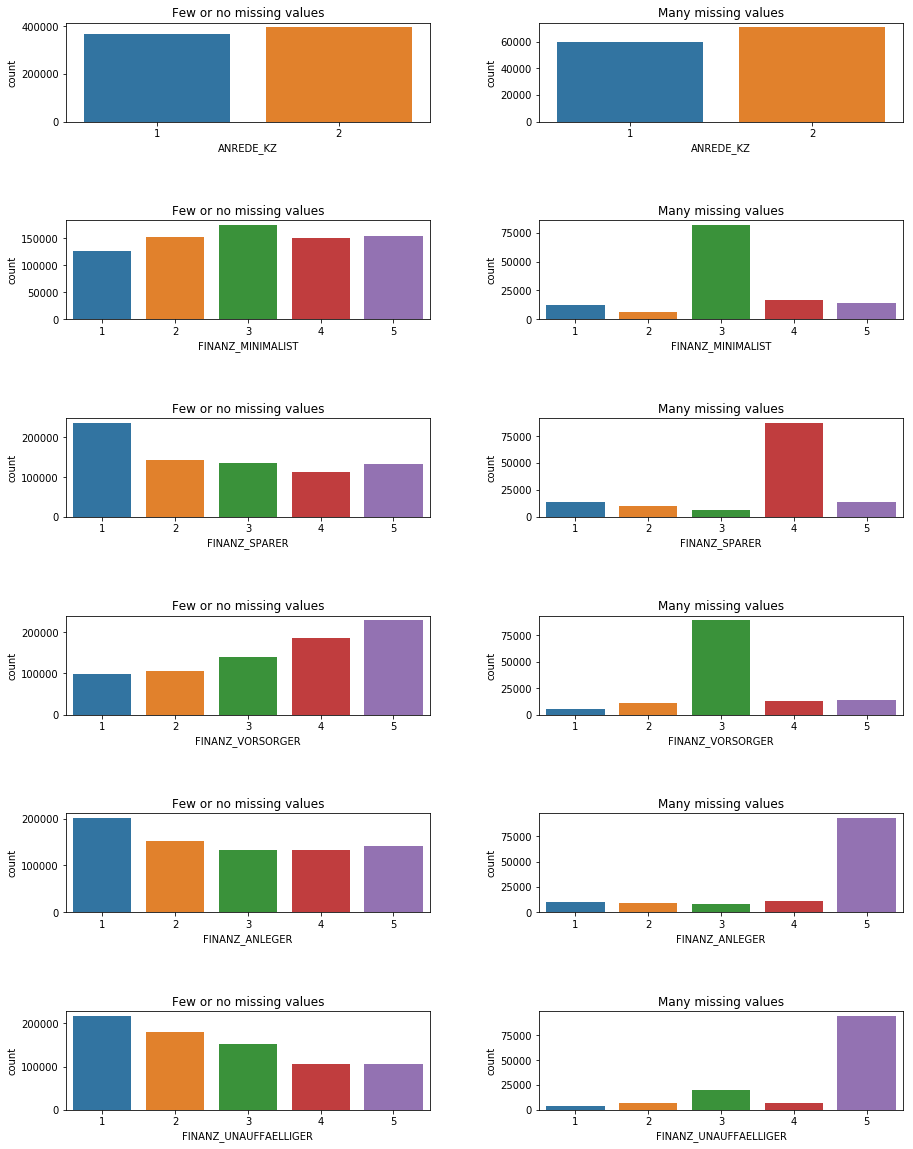

In [46]:
figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_columns)):
    sns.countplot(azdias_less[compare_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_more[compare_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

As per my observation around 131181 rows have more than 8 columns missing.The pattern of missing data is different in the two sets that I have separated.There seems to be different pattern of distribution of missing values in the two sets.The different patterns could be due to some unknown factor in the data and it would not be wise to remove it as the missing data is huge.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [47]:
# How many features are there of each data type?
features = list(azdias_less.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
data_type_count = feat_info_clean['type'].value_counts()
for i in range(len(data_type_count)):
    print('There are {} {} features.'.format(data_type_count[i], data_type_count.index[i]))


There are 49 ordinal features.
There are 18 categorical features.
There are 6 mixed features.
There are 6 numeric features.
There are 1 interval features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features =  feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
print(categorical_features)

binary_features = []
multi_features = []
for feature in categorical_features:
    if (len(azdias_less[feature].unique())==2):
        binary_features.append(feature)
    elif (len(azdias_less[feature].unique())>2):
        multi_features.append(feature)

print('Binary features are: {}'.format(binary_features))
print('Multi-level features are: {}'.format(multi_features))

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object
Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-level features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [49]:
for feature in binary_features:
    print('Unique values for {} are {}'.format(feature, azdias_less[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [1. 0.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [50]:
# Re-encode categorical variable(s) to be kept in the analysis.
new_values = {'W': 0, 'O': 1}
azdias_clean = azdias_less.replace({'OST_WEST_KZ':new_values})
for feature in multi_features:
    azdias_clean=azdias_clean.drop(feature, axis=1)

In [51]:
display(azdias_clean.head())

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

I accepted all binary features:'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'.Encoded the binary categorical features with values of 0 and 1. Dropped all multi-level features for now.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [52]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
gen_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

def map_gen(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan

In [54]:
# Create generation column
azdias_clean['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)

# Create movement column
azdias_clean['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)

In [55]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Map wealth 
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

# Map life stage
def map_lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [56]:
# Create wealth column
azdias_clean['CAMEO_INTL_2015_wealth'] = azdias_clean['CAMEO_INTL_2015'].apply(map_wealth)

# Create life stage column
azdias_clean['CAMEO_INTL_2015_lifestage'] = azdias_clean['CAMEO_INTL_2015'].apply(map_lifestage)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


We created maps for generation decade and movement and applied the same to get new features. Similarly the wealth and life stage features were made. The new features are ordinal, and thus don't need to be one hot encoded. The two original columns were then dropped

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
print(mixed_features)
for feature in mixed_features:
    azdias_clean.drop(feature, axis=1, inplace=True)
    

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for idx in range(len(feat_info)):
        unwanted = feat_info.iloc[idx]['missing_or_unknown']
        unwanted = unwanted.strip('[').strip(']').split(sep=',')

        unwanted = [float(value) if (value!='X' and value!='XX' and value!='') else value for value in unwanted]
        if unwanted != ['']:
            azdias = azdias.replace({feat_info.iloc[idx]['attribute']: unwanted}, np.nan)
            
    for col in azdias.columns:
        azdias = azdias.replace({col: ['XX', 'X']}, np.nan)
    
    # remove selected columns and rows, ...
    drop_columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']
    azdias = azdias.drop(drop_columns, axis=1)
    
    azdias_less = azdias[azdias.isnull().sum(axis=1) <= 8]
    
    new_values = {'W': 0, 'O': 1}
    azdias_clean = azdias_less.replace({'OST_WEST_KZ':new_values})
    
    features = list(azdias_less.columns)
    feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
    data_type_count = feat_info_clean['type'].value_counts()
    
    categorical_features =  feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    print(categorical_features)

    binary_features = []
    multi_features = []
    for feature in categorical_features:
        if (len(azdias_less[feature].unique())==2):
            binary_features.append(feature)
        elif (len(azdias_less[feature].unique())>2):
            multi_features.append(feature)
            
    for feature in multi_features:
        azdias_clean=azdias_clean.drop(feature, axis=1) 
        
        
    # select, re-encode, and engineer column values.
    gen_dict = {0: [1, 2], 1: [3, 4], 2: [5, 6, 7], 3: [8, 9], 4: [10, 11, 12, 13], 5:[14, 15]}

    def map_gen(x):
        try:
            for key, array in gen_dict.items():
                if x in array:
                    return key
        except ValueError:
            return np.nan
    
    # Map movement 
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    def map_mov(x):
        try:
            if x in mainstream:
                return 0
            else:
                return 1
        except ValueError:
            return np.nan
    
    # Create generation column
    azdias_clean['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)

    # Create movement column
    azdias_clean['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    # Map wealth 
    def map_wealth(x):
        # Check of nan first, or it will convert nan to string 'nan'
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[0])

    # Map life stage
    def map_lifestage(x):
        if pd.isnull(x):
            return np.nan
        else:
            return int(str(x)[1])
        
    # Create wealth column
    azdias_clean['CAMEO_INTL_2015_wealth'] = azdias_clean['CAMEO_INTL_2015'].apply(map_wealth)

    # Create life stage column
    azdias_clean['CAMEO_INTL_2015_lifestage'] = azdias_clean['CAMEO_INTL_2015'].apply(map_lifestage)
    
    
    # Return the cleaned dataframe.
    mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    print(mixed_features)
    for feature in mixed_features:
        azdias_clean.drop(feature, axis=1, inplace=True)
        
    return azdias_clean

In [6]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azd =  clean_data(azdias)

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [59]:
#azd = azdias_clean
#display(azd.head(n=25))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,5.0,0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,5.0,1,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,3.0,0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,3.0,0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,4.0,0,2.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0.0,4.0,4.0,2.0,5.0,2.0,3.0,0,1.0,4.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,4.0,1,1.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,5.0,1,1.0,5.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0.0,3.0,3.0,4.0,6.0,5.0,1.0,0,5.0,1.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [7]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

fill_missing = Imputer(strategy='most_frequent')
azdias_clean_imputed = pd.DataFrame(fill_missing.fit_transform(azd))

azdias_clean_imputed.columns = azd.columns
azdias_clean_imputed.index = azd.index

In [8]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_clean_scaled = scaler.fit_transform(azdias_clean_imputed)
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns=list(azdias_clean_imputed))
display(azdias_clean_scaled.head(n=15))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
0,-1.754749,0.962839,-1.509594,1.562326,-1.047360,1.490421,0.999842,1.338801,-0.535597,1.017084,...,0.420721,1.433798,0.561802,-0.178982,-0.130958,0.680934,1.120208,-0.569097,1.173365,-1.253702
1,0.200057,0.962839,-1.509594,0.885922,-1.771262,-0.557816,0.279458,1.338801,1.867075,1.017084,...,-0.954737,0.403968,0.561802,-0.178982,-0.130958,-0.794257,1.120208,1.757169,-0.871489,0.760200
2,1.177461,0.962839,0.679658,-0.466884,1.124348,-0.557816,-1.161312,-0.812897,-0.535597,-0.305447,...,-0.954737,-0.625863,0.561802,-1.182169,-1.001874,-0.056662,-0.245948,-0.569097,-1.553107,-0.582401
3,0.200057,-1.038595,0.679658,0.209519,0.400446,-1.240562,0.279458,-0.812897,-0.535597,1.017084,...,0.420721,-0.625863,-0.340700,0.824206,0.304500,1.418529,-0.245948,-0.569097,0.491747,0.088899
4,-1.754749,0.962839,-0.050093,-1.143288,1.124348,-0.557816,-0.440927,1.338801,-0.535597,1.017084,...,0.420721,1.433798,1.464303,-1.182169,-1.001874,-0.056662,-1.612105,-0.569097,1.173365,0.760200


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature 
scaling.)

I replaced all missing values with the most frequent value in that column using the Imputer method. All features are scaled uding the StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [9]:
# Apply PCA to the data.
print(azdias_clean_scaled.shape[1])

pca = PCA()
pca.fit(azdias_clean_scaled)

64


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

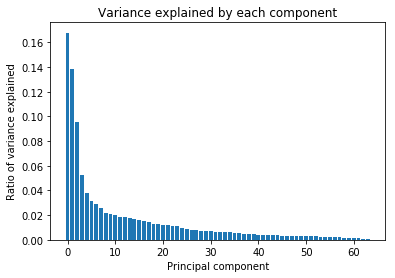

In [10]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


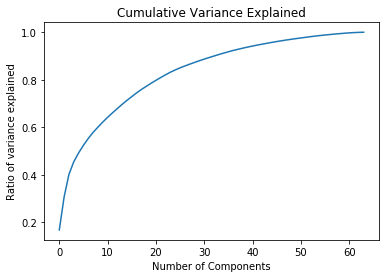

In [11]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_30 = PCA(n_components=30)
azdias_pca = pca_30.fit_transform(azdias_clean_scaled)
print(azdias_pca)


[[ 4.10076718 -2.44451045 -2.84073328 ... -0.25139398  0.9559922
  -0.05373992]
 [-0.84862395  0.0837821  -3.12891049 ... -0.97458207 -0.95356552
   0.09915036]
 [-3.92989034  1.19913996 -0.68649402 ...  0.26012025 -0.33399857
  -0.39059525]
 ...
 [-0.59992369 -3.31908812 -2.72855056 ...  0.88992364 -0.42378155
  -1.87666781]
 [ 6.06840708 -2.84727853  2.42306755 ... -0.33858882 -0.12640844
   0.03038531]
 [-0.77841113  0.96747457  3.00767278 ... -0.40938525  0.11783748
   0.69362061]]


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I am picking 30 principal components as it seems to explain more than 80% of variance.Also my features are reduced by half.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

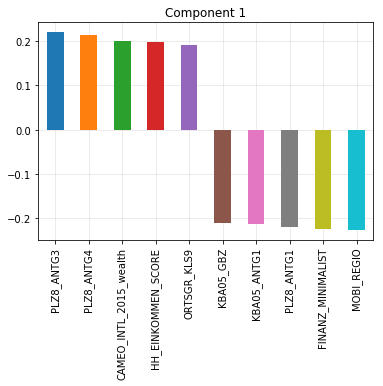

In [13]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_pca(data, pca, n_compo):

    compo = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_compo-1]
    compo.sort_values(ascending=False, inplace=True)
    compo = pd.concat([compo.head(5), compo.tail(5)])
    
    compo.plot(kind='bar', title='Component ' + str(n_compo))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    
plot_pca(azdias_clean_scaled, pca_30, 1)

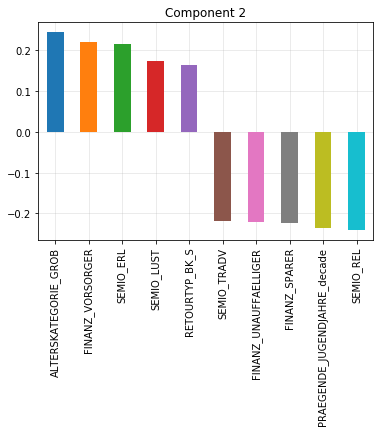

In [14]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(azdias_clean_scaled, pca_30, 2)


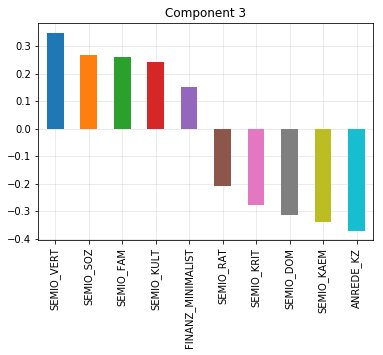

In [15]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca(azdias_clean_scaled, pca_30, 3)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1) First principal component shows positive correlation among PLZ8_ANTG3, PLZ8_ANTG4 and CAMEO_INTL_2015_wealth. It shows negative correlation with FINANZ_MINIMALIST, PLZ8_ANTG1, MOBI_REGIO. Seems like number of 6-10 family houses and 10+ family houses tend to increase together and this may be an indication of low wealth as wealthy people prefer to stay in nuclear families. This is indicated by the increment in CAMEO_INTL_2015_wealth feature. This suggest high movement in these regions. This can be asserted by the negative correlation with 1-2 family houses, less movement, and financial status.

2) This shows some financial status/habits relation with age and personality traits of a person. As ALTERSKATEGORIE_GROB increases FINANZ_VORSORGER , SEMIO_ERL increases and have negative correlation with youth ( PRAEGENDE_JUGENDJAHRE_decade) and FINANZ_SPARER, SEMIO_REL traits.

3)Third principal component shows positive and negative correlation of gender with certain personality traits. They seem to be closely related as they all depict some characteristics of a person.
Female gender seems to have negative correlation with certain traits SEMIO_VERT, SEMIO_FAM and SEMIO_SOZ.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [16]:
# Over a number of different cluster counts...
def k_mean_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    print("Score is {} for {} clusters".format(score, n_cluster))
    return score

scores = []
ks = list(range(10,25))
for k in ks:
    scores.append(k_mean_score(azdias_pca, k))

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

Score is 25797801.06640954 for 10 clusters
Score is 25395367.386297036 for 11 clusters
Score is 24719299.75079118 for 12 clusters
Score is 24450728.061486065 for 13 clusters
Score is 23835347.392435037 for 14 clusters
Score is 23692600.729079816 for 15 clusters
Score is 23185873.400563486 for 16 clusters
Score is 23273196.431665108 for 17 clusters
Score is 22735476.734081145 for 18 clusters
Score is 22468334.11621895 for 19 clusters
Score is 22226393.78789565 for 20 clusters
Score is 21904650.48451206 for 21 clusters
Score is 21747321.864910875 for 22 clusters
Score is 21674865.6648313 for 23 clusters
Score is 21353557.5769775 for 24 clusters


Text(0,0.5,'SSE')

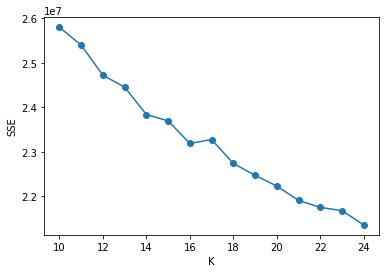

In [17]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('K')
plt.ylabel('SSE')

In [42]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 16)
model_16 = kmeans.fit(azdias_pca)
azdias_pred = model_16.predict(azdias_pca)
print(azdias_pred)

[ 7 13 15 ...  2  3  4]


###### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Based on the graph above I see an elbow aroung k= 16, and though we see a dip in score after that point as well it is less steep. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [43]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')


In [44]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)
print(customers_clean)




2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object
        ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        4.0          1                  5              1   
2                        4.0          2                  5              1   
3                        4.0          1                  5              1   
4                        3.0          1         

In [45]:
customers_clean_imputed = pd.DataFrame(fill_missing.fit_transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

customers_clean_scaled = scaler.transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))
# PCA transformation
customers_pca = pca_30.transform(customers_clean_scaled)

customers_pred = model_16.predict(customers_pca)

In [46]:
print(customers_pred)

[12  0  4 ... 12 15  4]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

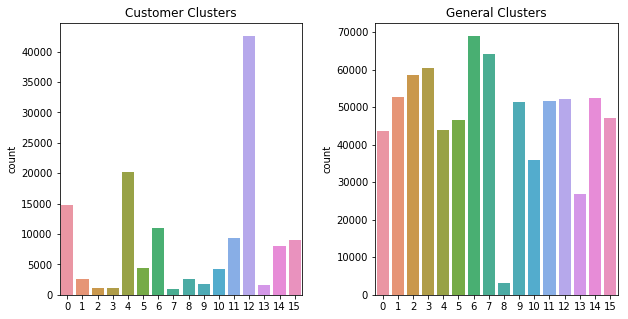

In [47]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')

In [48]:
print(len(customers_clean_scaled))
print(len(azdias_clean_scaled))

48000.0/760040

135495
760040


0.06315457081206252

In [49]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# I think cluster 12 is the overrrepresented cluster
# and cluster 7 is the underrepresented one

centroid_12 = scaler.inverse_transform(pca_30.inverse_transform(model_16.cluster_centers_[12]))
overrepresented_customers = pd.Series(data = centroid_12, index = customers_clean.columns)


In [36]:
overrepresented_customers

ALTERSKATEGORIE_GROB                 3.403109
ANREDE_KZ                            1.059423
FINANZ_MINIMALIST                    4.972000
FINANZ_SPARER                        1.407614
FINANZ_VORSORGER                     4.405035
FINANZ_ANLEGER                       1.351669
FINANZ_UNAUFFAELLIGER                1.968468
FINANZ_HAUSBAUER                     1.942160
GREEN_AVANTGARDE                     0.968175
HEALTH_TYP                           2.029514
RETOURTYP_BK_S                       4.060467
SEMIO_SOZ                            4.809152
SEMIO_FAM                            4.734848
SEMIO_REL                            3.664059
SEMIO_MAT                            3.795054
SEMIO_VERT                           6.213658
SEMIO_LUST                           5.390651
SEMIO_ERL                            4.218953
SEMIO_KULT                           4.803831
SEMIO_RAT                            2.604453
SEMIO_KRIT                           3.091772
SEMIO_DOM                         

In [50]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_7 = scaler.inverse_transform(pca_30.inverse_transform(model_18.cluster_centers_[7]))
underrepresented_customers = pd.Series(data = centroid_7, index = customers_clean.columns)

In [41]:
underrepresented_customers

ALTERSKATEGORIE_GROB                 2.962616
ANREDE_KZ                            1.068745
FINANZ_MINIMALIST                    3.200315
FINANZ_SPARER                        2.873787
FINANZ_VORSORGER                     3.271867
FINANZ_ANLEGER                       2.395194
FINANZ_UNAUFFAELLIGER                2.544360
FINANZ_HAUSBAUER                     2.713183
GREEN_AVANTGARDE                     0.084862
HEALTH_TYP                           2.888417
RETOURTYP_BK_S                       4.036160
SEMIO_SOZ                            5.110548
SEMIO_FAM                            5.289525
SEMIO_REL                            4.186849
SEMIO_MAT                            4.222534
SEMIO_VERT                           5.531453
SEMIO_LUST                           4.234951
SEMIO_ERL                            4.003982
SEMIO_KULT                           5.301170
SEMIO_RAT                            3.038872
SEMIO_KRIT                           4.018058
SEMIO_DOM                         

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

I can see some clear contrast among the overrepresented and underrepresented customers.Few of them are below


PLZ8_ANTG1                           2.798314
PLZ8_ANTG2                           2.524572
PLZ8_ANTG3                           1.156321
PLZ8_ANTG4                           0.372267

CAMEO_INTL_2015_wealth               2.077910
MOBI_REGIO                           4.135440
PRAEGENDE_JUGENDJAHRE_decade         2.445997

#####################


PLZ8_ANTG1                           1.735168
PLZ8_ANTG2                           3.417714
PLZ8_ANTG3                           2.164768
PLZ8_ANTG4                           0.937352

CAMEO_INTL_2015_wealth               4.122656
MOBI_REGIO                           2.240640
PRAEGENDE_JUGENDJAHRE_decade         3.573780

This shows that the population who is popular with the mail-order company are more of nuclear families, with good wealth status. they seem to be the ecomonically well to do section of the poulation, who are relatively yournger tan the unpopular ones. And that is nwhy we see less movement in this cluster.

The unpopular ones in contrast have higher  share of 6-10 family homes, wealth is low and movement is high. This represents the financially weaker sections of the poulation.

Clsutering information was able to bring out this demarcation , which can be a good market strategy as to how to target customers and design your marketing campaigns.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.